# 1. Project Background

Today, burnout is often described as 'The Great Exhaustion' because according to a study published by Mercer in 2024, 8 out of 10 employees are at risk of burnout. It thus comes as no surprise that HR departments are very interested in monitoring their employees' burnout rate. Understanding and predicting employee burnout rates can provide organizations with the right insights to create supportive and healthy environments in the workplace.

This project aims to build a machine learning model to predict employee burnout rate from data such as gender, hours worked per day, designation, and the like.

# 2. Load Libraries & Data

In [40]:
# Impoting general libraries
import warnings
import itertools
import random

# Data Analysis Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mn

# Data Preparation, Modeling, and Evaluation (SKLearn Modules)
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler,RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Class Imbalance
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Machine Learning Models 
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier

# Machine Learning Model Evaluation Methods 
from sklearn.metrics import mean_squared_error

warnings.filterwarnings(action="ignore")
%matplotlib inline

In [41]:
#load train data set
train_df=pd.read_csv(r"C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\Week5_CapstoneProject\dataset\train.csv")
train_df.head()

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52


# 3. EDA

### 3.1 Missingness

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


From this , we see that only 3 features including the target variable has missing values.

<Axes: >

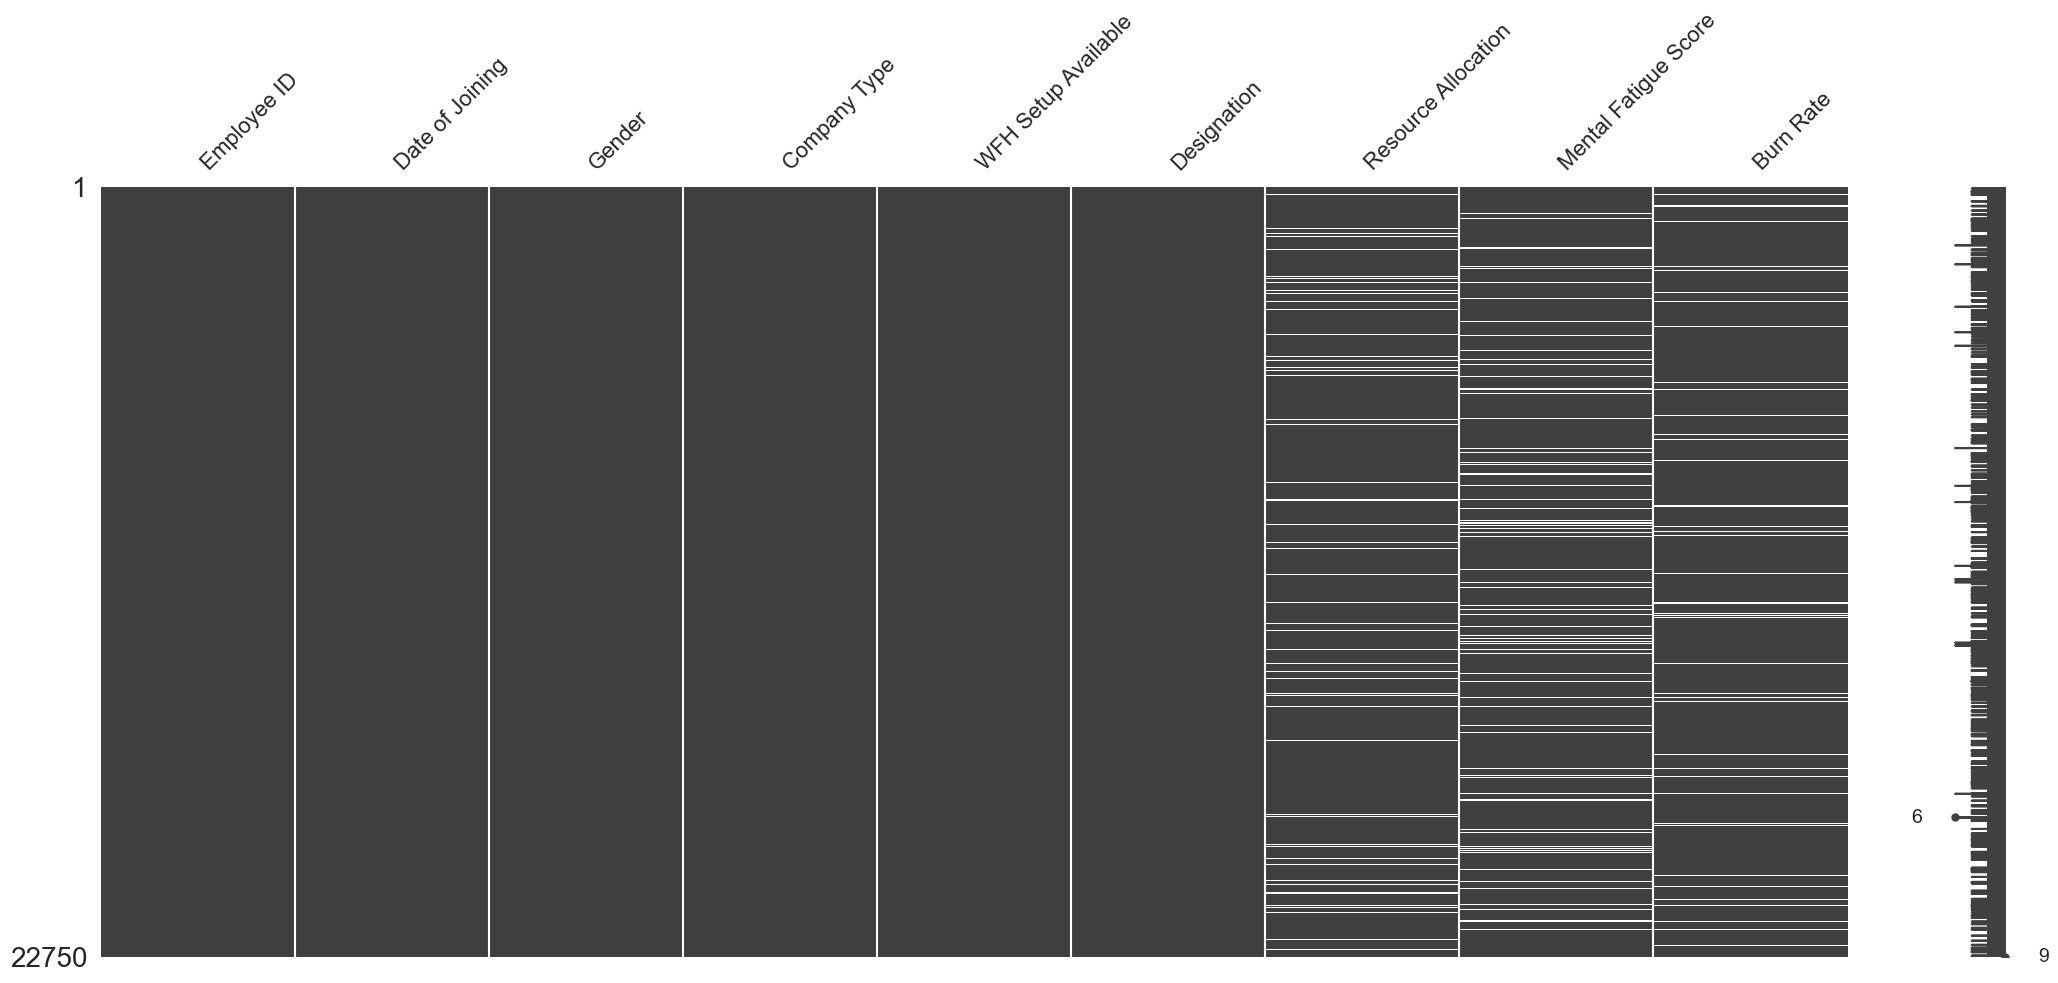

In [43]:
#plot matrix to visualize missingness
mn.matrix(train_df)

It is not advisable to impute rows with missing target variable, so drop all rows where the target variable is missing

<Axes: >

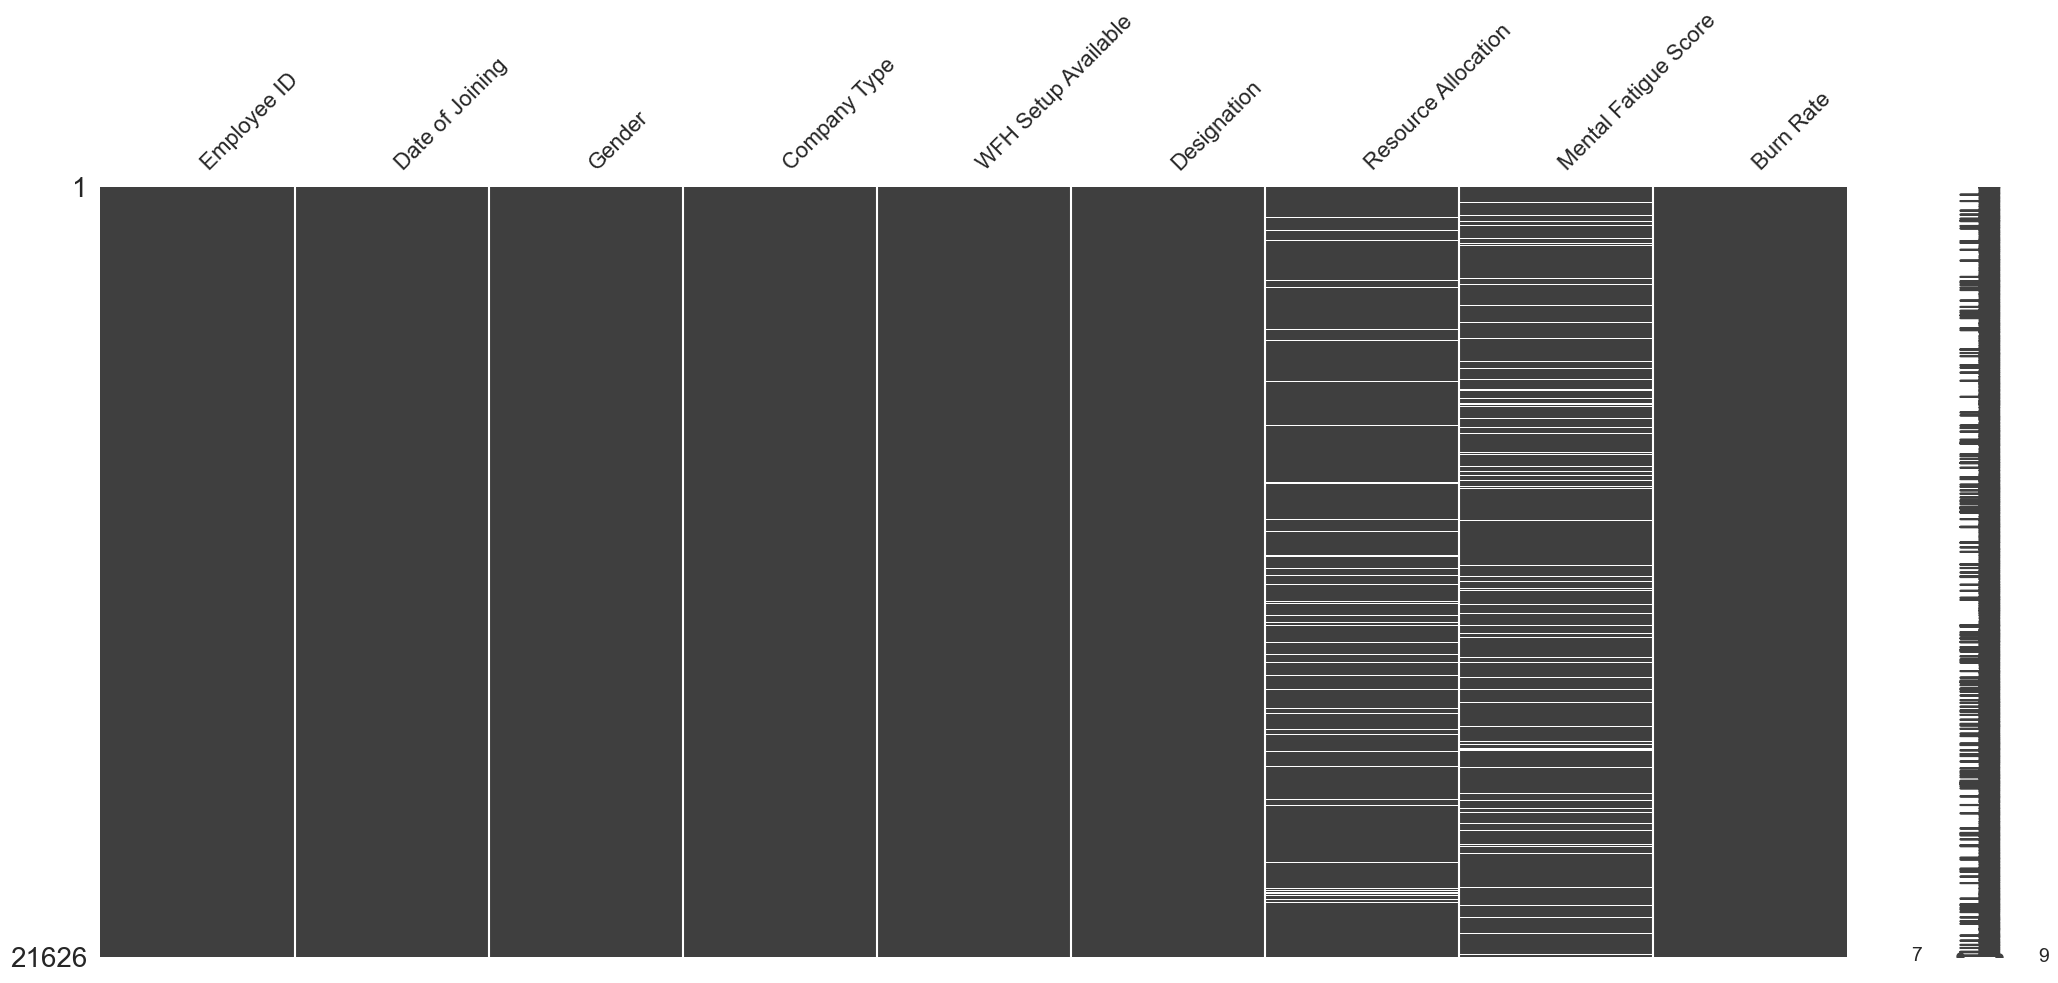

In [44]:
#drop null rows in the target column
train_df.dropna(subset=['Burn Rate'], inplace=True)
mn.matrix(train_df)

Now we need to calculate the proprotion of missingness in each column with missing values, in order to decide whether to drop or impute the data.

In [45]:
total_missing=train_df.isnull().sum().sort_values(ascending=False)
percent=train_df.isnull().sum().sort_values(ascending=False)/train_df.isnull().count().sort_values(ascending=False)
missing_df=pd.concat([total_missing,percent],axis=1,keys=['total_missing','percentage_missing'],sort=False)
missing_df.index.name='variable'# set the index name to variable 
missing_df=missing_df[total_missing>0] # only retain those with missing values 
missing_df['percentage_missing']=missing_df['percentage_missing'].map(lambda x:x*100) # convert to percentage 
missing_df

,total_missing,percentage_missing
variable,,
Mental Fatigue Score,1945,8.993804
Resource Allocation,1278,5.909553


Because each column has less very little missing values, we can proceed to impute values. To decide how to impute the values, we first explore the distribution of each variable with missing values.

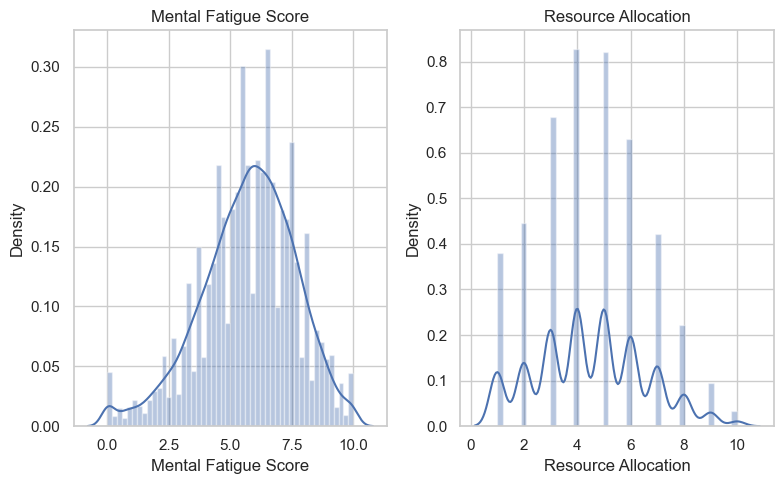

In [46]:
columns_to_plot=['Mental Fatigue Score','Resource Allocation']
fig = plt.figure(figsize=(8,5))
for i, column in enumerate(columns_to_plot):
    ax = fig.add_subplot(1, 2, i + 1)  
    sns.distplot(train_df[column],ax=ax)
    ax.set_title(column)
plt.tight_layout()
plt.show()

### Insights from distribution plots:
Mental Fatigue score has a normal distribution and therefore missing values can be imputed using mean.
Resource allocation has many peaks, therefore median imputation is best

In [47]:
#use fillna to impute
train_df['Mental Fatigue Score'].fillna(train_df['Mental Fatigue Score'].mean(),inplace=True)
train_df['Resource Allocation'].fillna(train_df['Resource Allocation'].median(),inplace=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21626 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           21626 non-null  object 
 1   Date of Joining       21626 non-null  object 
 2   Gender                21626 non-null  object 
 3   Company Type          21626 non-null  object 
 4   WFH Setup Available   21626 non-null  object 
 5   Designation           21626 non-null  float64
 6   Resource Allocation   21626 non-null  float64
 7   Mental Fatigue Score  21626 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


### 3.2 Outliers

In [48]:
#separte the dataframe into numerical and categorical data
num_df=train_df.select_dtypes(include=[np.number])
cat_df=train_df.select_dtypes(include=[object])

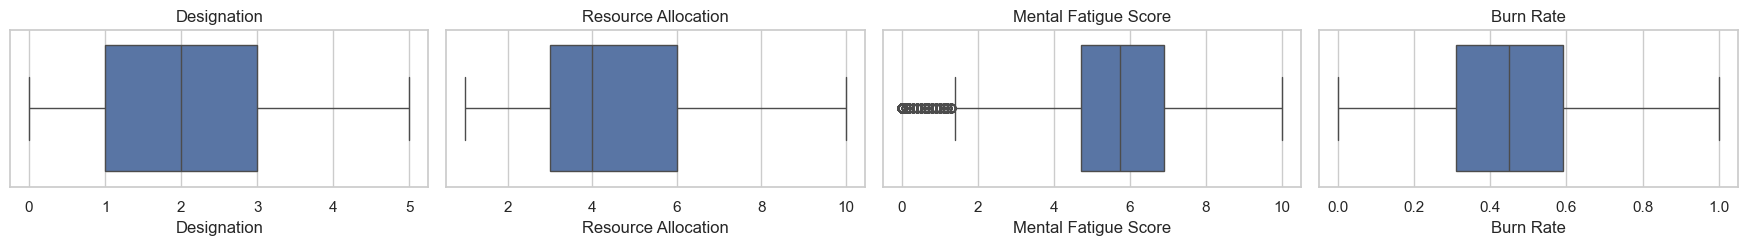

In [49]:
fig = plt.figure(figsize=(22,20))
for i in range(len(num_df.columns)):
    ax=fig.add_subplot(9, 5, i+1)
    sns.boxplot(x=num_df.iloc[:, i],ax=ax)
    ax.set_title(num_df.columns[i])
plt.tight_layout()
plt.show()

In [ ]:
exclude_columns=['Employee ID','Date of Joining']
fig = plt.figure(figsize=(20,18))
for i in range(len(cat_df.columns)):
    if i not in exclude_columns:
        ax= fig.add_subplot(9, 5, i+1)
        sns.countplot(x=cat_df.iloc[:, i],ax=ax)
plt.tight_layout()
plt.show()

## ask how come the excluded columns are still being plotted****

### 3.3 Correlation

In [ ]:
#correlation matrix
corrmat = num_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,5))
g=sns.heatmap(num_df[top_corr_features].corr(),annot=True,cmap="viridis")

### 3.4 Bivariate Analysis

In [ ]:
#Relationship between mental fatigue score and burn rate, gender and burn rate and company type and burnrate
sns.set(style="whitegrid")

fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
ax[0].set_title("Mental Fatigue Vs Burn rate")
sns.scatterplot(x='Mental Fatigue Score',y= 'Burn Rate', data= train_df,ax=ax[0])
ax[1].set_title("Gender Vs Burn Rate")
sns.violinplot(y='Burn Rate',x='Gender',data= train_df, ax=ax[1])
ax[2].set_title("Company Type Vs Burn Rate")
sns.boxplot(y='Burn Rate',data=train_df,x='Company Type',ax=ax[2])

Insights from Bivariate Analysis:
1. Burnout rate is directly proportional to Mental Fatigue score
2. Among both male and female employees,for majority, their burnout rate lies between o.4 and 0.6
3. There is very little difference in the burnout rate of employees in 'service' and 'product' departments.


# 4. Data Preprocessing

### 4.1 Feature Engineering

In my dataset we have the variable, 'Date of Joining', we can create another variable from this-'Tenure', which is how long each employee has been with the company to date.
NOTE: An assumption is made here: that the burnout rates were collected this year.

In [15]:
#first change the date column to datetime
from datetime import datetime
train_df['Date of Joining']=pd.to_datetime(train_df['Date of Joining'])
#get the date today
today=datetime.now()
# function that calculates months
def tenure_calc(join_date):
    total_months=(today.year-join_date.year)*12 + today.month-join_date.month
    return total_months

In [16]:
train_df['Tenure_in_months']=train_df['Date of Joining'].apply(tenure_calc)
#train_df.head(20)

### 4.2 Data Encoding

We will use OneHot Encoding to transform the categorical data because the columns in the original dataframe are not too many!

In [21]:
#drop employee ID and Date of Joining
cat_df.drop(['Employee ID','Date of Joining'],axis=1,inplace=True)
cat_df.head()

,Gender,Company Type,WFH Setup Available
0,Female,Service,No
1,Male,Service,Yes
2,Female,Product,Yes
3,Male,Service,Yes
4,Female,Service,No


In [27]:
ohe=OneHotEncoder(sparse_output=False)
ohe_transform=ohe.fit_transform(cat_df)
encoded_df = pd.DataFrame(ohe_transform, columns=ohe.get_feature_names_out(cat_df.columns))
#combine with original dataframe to form the final dataframe
data=pd.concat([train_df,encoded_df],axis=1)
data.drop(['Employee ID','Date of Joining','Gender','Company Type','WFH Setup Available'],axis=1,inplace=True)
data.head()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Tenure_in_months,Gender_Female,Gender_Male,Company Type_Product,Company Type_Service,WFH Setup Available_No,WFH Setup Available_Yes
0,2.0,3.0,3.8,0.16,189.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,2.0,5.0,0.36,187.0,0.0,1.0,0.0,1.0,0.0,1.0
2,2.0,4.0,5.8,0.49,195.0,1.0,0.0,1.0,0.0,0.0,1.0
3,1.0,1.0,2.6,0.20,187.0,0.0,1.0,0.0,1.0,0.0,1.0
4,3.0,7.0,6.9,0.52,191.0,1.0,0.0,0.0,1.0,1.0,0.0


# 5. Modelling with preprocessed data

Predicting the burnout rate based on employee metrics is a regression problem.For the project we will apply a simple linear regression model, support vector machine and random forest.

In [29]:
#split the data
X=data.drop('Burn Rate',axis=1)
y=data[['Burn Rate']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18162, 10) (4541, 10) (18162, 1) (4541, 1)


In [38]:
X_train.isnull()

,Designation,Resource Allocation,Mental Fatigue Score,Tenure_in_months,Gender_Female,Gender_Male,Company Type_Product,Company Type_Service,WFH Setup Available_No,WFH Setup Available_Yes
9657,False,False,False,False,False,False,False,False,False,False
7761,False,False,False,False,False,False,False,False,False,False
20240,False,False,False,False,False,False,False,False,False,False
19810,False,False,False,False,False,False,False,False,False,False
15344,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
13959,True,True,True,True,False,False,False,False,False,False
4102,False,False,False,False,False,False,False,False,False,False
15492,False,False,False,False,False,False,False,False,False,False
4581,False,False,False,False,False,False,False,False,False,False


In [36]:
#regression with OLS
#initiate the model,specificy the evaluation metric, apply cross validation of 5 folds
reg=LinearRegression()
mse_score=make_scorer(mean_squared_error,greater_is_better=False)
scores=cross_val_score(reg, X_train, y_train,cv=5,scoring=mse_score)
print(scores,scores.mean())

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\venv\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\venv\Lib\site-packages\sklearn\linear_model\_base.py", line 578, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\venv\Lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\venv\Lib\site-packages\sklearn\utils\validation.py", line 1263, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\venv\Lib\site-packages\sklearn\utils\validation.py", line 1049, in check_array
    _assert_all_finite(
  File "C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\venv\Lib\site-packages\sklearn\utils\validation.py", line 126, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "C:\Users\User\Desktop\Zindua_Class_Data\Machine_Learning_Class1\venv\Lib\site-packages\sklearn\utils\validation.py", line 175, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
